<a href="https://www.kaggle.com/code/kadenchow/mnist-datatset-neural-network-practice?scriptVersionId=283192583" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [7]:
Y_train

array([9, 8, 8, ..., 0, 4, 1])

In [8]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def LeakyReLU(Z):
    """Forward pass for Leaky ReLU: A = max(alpha * Z, Z)"""
    return np.maximum(ALPHA_LEAKY * Z, Z)

def sigmoid(Z):
    """Forward pass for Sigmoid: A = 1 / (1 + exp(-Z))"""
    return 1 / (1 + np.exp(-Z))

def tanh(Z):
    """Forward pass for Tanh: A = tanh(Z)"""
    return np.tanh(Z)

def gelu_cdf_approx(Z):
    """Approximation of the Cumulative Distribution Function (CDF) for standard normal."""
    return 0.5 * (1.0 + np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z**3)))

def GeLU(Z):
    """Forward pass for GeLU: A = Z * CDF_approx(Z)"""
    return Z * gelu_cdf_approx(Z)

## Forward Propogation Function ##
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    # Modify Activation Function 
    A1 = GeLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## Activation Layers ##
def ReLU_deriv(Z):
    return Z > 0
    
def LeakyReLU_deriv(Z):
    """Derivative of Leaky ReLU: alpha if Z < 0, 1 if Z >= 0."""
    dZ = np.ones_like(Z)
    dZ[Z < 0] = ALPHA_LEAKY
    return dZ

def sigmoid_deriv(A):
    """Derivative of Sigmoid: A * (1 - A). Requires the forward activation A."""
    return A * (1 - A)

def tanh_deriv(A):
    """Derivative of Tanh: 1 - A^2. Requires the forward activation A."""
    return 1 - np.power(A, 2)

# Optimal: Gaussian Error Linear Unit (GeLU)
def GeLU_deriv(Z):
    """Derivative of GeLU (using the approximation derivative)."""
    
    # Constants for the approximation derivative
    c1 = np.sqrt(2 / np.pi)
    c2 = 0.044715
    
    tanh_arg = c1 * (Z + c2 * Z**3)
    sech_sq = 1.0 / np.cosh(tanh_arg)**2 # sech^2(x) = 1 / cosh^2(x)
    
    d_tanh_arg_dZ = c1 * (1 + 3 * c2 * Z**2)
    
    cdf_approx = gelu_cdf_approx(Z)
    
    # Derivative formula: A' = CDF + Z * (d/dZ CDF)
    return cdf_approx + Z * (0.5 * sech_sq * d_tanh_arg_dZ)

## Optimized Softmax Function ##
def softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

## One Hot Encoding ##
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

## Backpropgation Function ##
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1] # <-- FIX 1: Define 'm' (number of examples)
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    # FIX 2: Sum over examples (axis=1) and keep dimensions
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) 
    
    # Modify Thresholding Layer
    dZ1 = W2.T.dot(dZ2) * GeLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    # FIX 3: Sum over examples (axis=1) and keep dimensions
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) 
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1 
    W2 = W2 - alpha * dW2 
    b2 = b2 - alpha * db2  
    return W1, b1, W2, b2

def cross_entropy_loss(A2, Y):
    """
    Calculates the categorical cross-entropy loss.
    A2 (predictions) is shape (10, m)
    Y (true labels) is shape (m,) [e.g., [5, 0, 4, ...]]
    """
    m = Y.shape[0] # Number of examples
    
    # Clip A2 to avoid log(0)
    epsilon = 1e-12
    A2 = np.clip(A2, epsilon, 1. - epsilon)
    
    # Select the predicted probabilities for the correct class
    # A2[Y, np.arange(m)] selects:
    #   For example 0 (col 0), the probability at class Y[0]
    #   For example 1 (col 1), the probability at class Y[1]
    #   ...and so on for all 'm' examples
    correct_log_probs = -np.log(A2[Y, np.arange(m)])
    
    # Compute the average loss
    loss = np.sum(correct_log_probs) / m
    return loss

    # Optimization: MSE, prioritize penalizing larger errors (always >0)
def mean_absolute_error_loss(A2, Y):
    m = Y.shape[0]
    predictions = np.argmax(A2, axis=0)
    
    absolute_differences = np.abs(Y - predictions)
    mae_loss = np.sum(absolute_differences) / m
    return mae_loss

In [9]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def stochastic_gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    # Track Loss Values
    loss_history = []
    # Track MAE Values
    mae_history = []

    # Track Weights and Biases Values
    w1_history = []
    b1_history = []
    w2_history = []
    b2_history = []
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 50 == 0:
            print("Epoch:", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            
        if i % 1 == 0: # Calculate and store every epoch
            current_loss = cross_entropy_loss(A2, Y) 
            loss_history.append(current_loss)
            current_mae = mean_absolute_error_loss(A2, Y)
            mae_history.append(current_mae)

            w1_history.append(np.mean(W1))
            b1_history.append(np.mean(b1))
            w2_history.append(np.mean(W2))
            b2_history.append(np.mean(b2))
            
            if i % 50 == 0:
                print(f"Iteration {i+1}/{iterations} | Loss: {current_loss:.4f}")
                print(f"  W1 Mean: {w1_history[-1]:.3f} | b1 Mean: {b1_history[-1]:.3f}")

    histories = {
        'loss': loss_history,
        'mae': mae_history,
        'w1': w1_history,
        'b1': b1_history,
        'w2': w2_history,
        'b2': b2_history
            }
        
    return W1, b1, W2, b2, histories

In [10]:
W1, b1, W2, b2, histories = stochastic_gradient_descent(X_train, Y_train, 0.2, 501)

Epoch: 0
[1 4 2 ... 4 4 5] [9 8 8 ... 0 4 1]
0.123
Iteration 1/501 | Loss: 2.3159
  W1 Mean: -0.001 | b1 Mean: -0.071
Epoch: 50
[7 3 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.8347317073170731
Iteration 51/501 | Loss: 0.6508
  W1 Mean: 0.006 | b1 Mean: 0.007
Epoch: 100
[7 3 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.8831219512195122
Iteration 101/501 | Loss: 0.4329
  W1 Mean: 0.008 | b1 Mean: 0.024
Epoch: 150
[7 8 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.8967073170731708
Iteration 151/501 | Loss: 0.3704
  W1 Mean: 0.009 | b1 Mean: 0.031
Epoch: 200
[7 8 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.9037073170731708
Iteration 201/501 | Loss: 0.3402
  W1 Mean: 0.009 | b1 Mean: 0.035
Epoch: 250
[7 8 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.9084878048780488
Iteration 251/501 | Loss: 0.3215
  W1 Mean: 0.009 | b1 Mean: 0.038
Epoch: 300
[7 8 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.9122926829268293
Iteration 301/501 | Loss: 0.3083
  W1 Mean: 0.009 | b1 Mean: 0.040
Epoch: 350
[7 8 8 ... 0 4 1] [9 8 8 ... 0 4 1]
0.9151707317073171
Iteration 351/501 | 

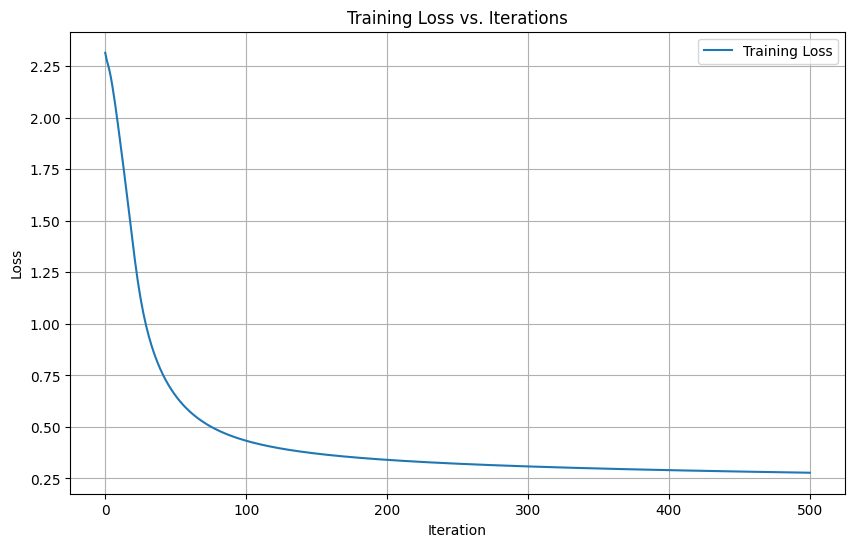

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(histories['loss'], label='Training Loss')
plt.title('Training Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

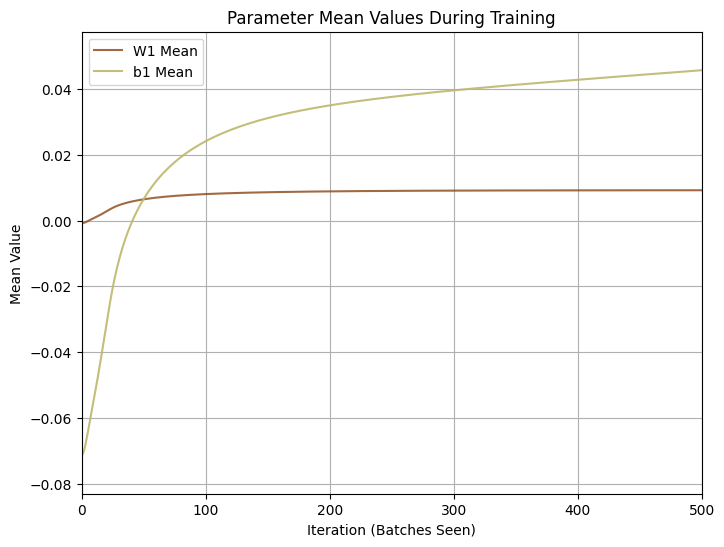

In [12]:
iterations = range(len(histories['w1']))

plt.figure(figsize=(8, 6))
plt.plot(iterations, histories['w1'], label='W1 Mean', color='#8B4513', alpha=0.8) # Brown
plt.plot(iterations, histories['b1'], label='b1 Mean', color='#BDB76B', alpha=0.9) # Dark Yellow

#plt.axhline(y=0.140, color='#8B4513', linestyle='--')
#plt.axhline(y=0.0125, color='#BDB76B', linestyle='--')

all_param_data = np.concatenate([
    histories['w1'], 
    histories['b1'],
    histories['w2'], 
    histories['b2']
])

y_min = np.min(all_param_data)
y_max = np.max(all_param_data)
y_padding = (y_max - y_min) * 0.1

plt.ylim(y_min - y_padding, y_max + y_padding)

plt.title('Parameter Mean Values During Training')
plt.xlabel('Iteration (Batches Seen)')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.xlim(0, max(iterations)) # Set X-axis limits
plt.show()

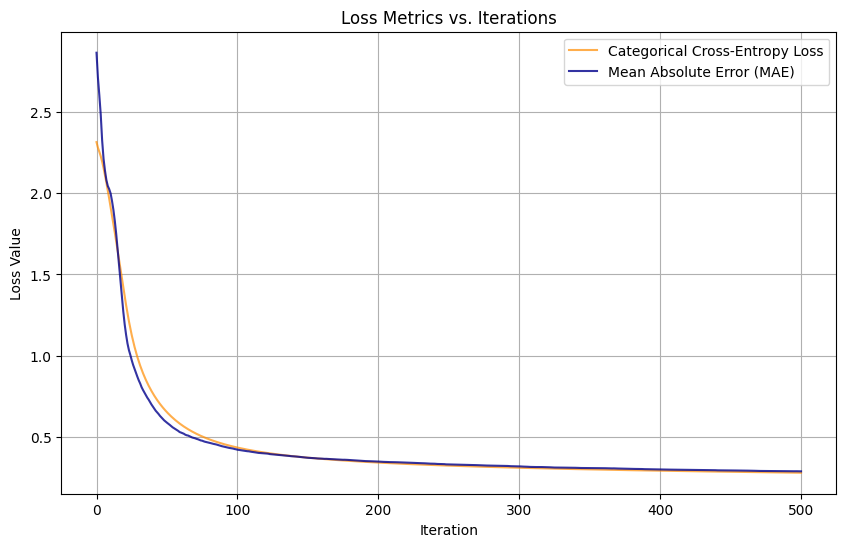

Final Mean Absolute Error (MAE): 0.2863


In [13]:
iterations = range(len(histories['mae']))

plt.figure(figsize=(10, 6))
plt.plot(iterations, histories['loss'], label='Categorical Cross-Entropy Loss', color='darkorange', alpha=0.7)
plt.plot(iterations, histories['mae'], label='Mean Absolute Error (MAE)', color='darkblue', alpha=0.8) 

plt.title('Loss Metrics vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

mae_history = histories['mae']
final_mae = mae_history[-1]

print(f"Final Mean Absolute Error (MAE): {final_mae:.4f}")

In [14]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [7]
Label:  9


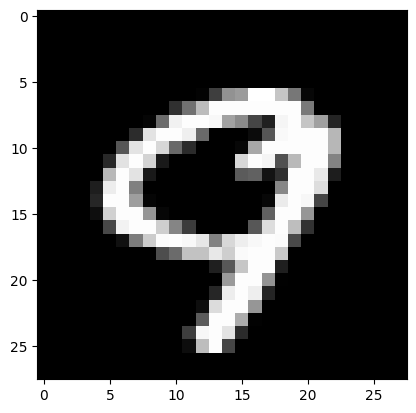

Prediction:  [8]
Label:  8


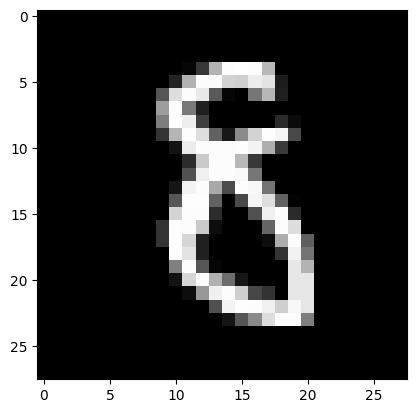

Prediction:  [8]
Label:  8


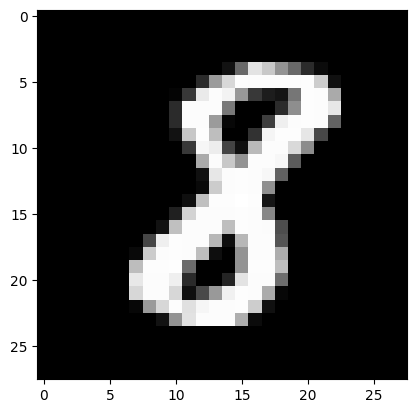

Prediction:  [9]
Label:  9


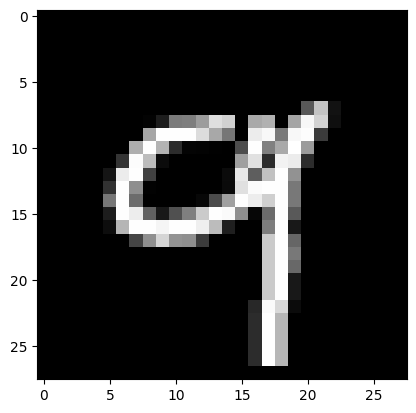

Prediction:  [9]
Label:  9


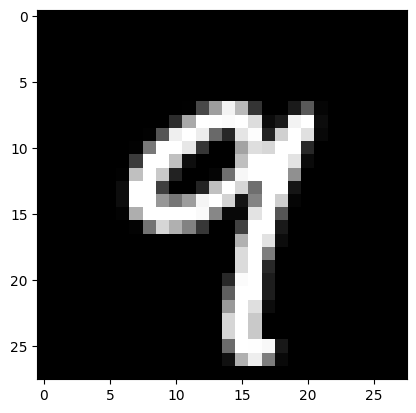

Prediction:  [1]
Label:  1


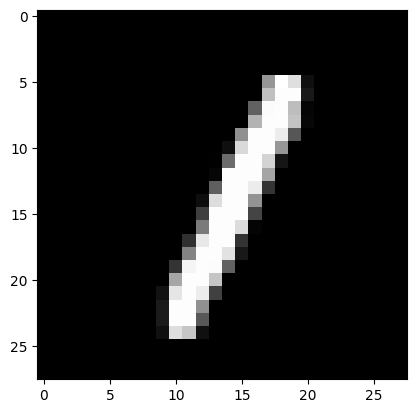

Prediction:  [0]
Label:  0


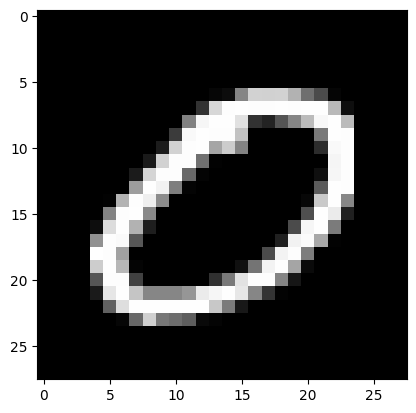

Prediction:  [7]
Label:  7


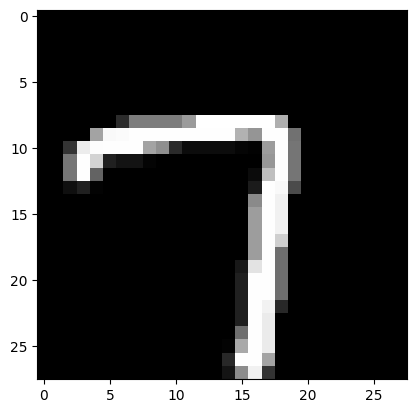

Prediction:  [1]
Label:  1


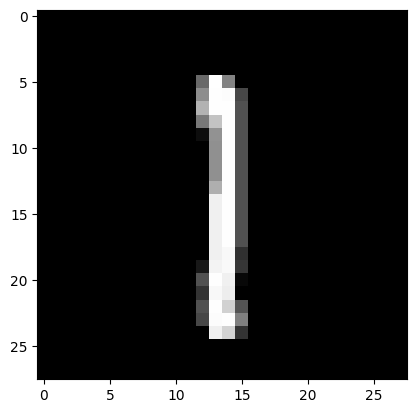

Prediction:  [4]
Label:  4


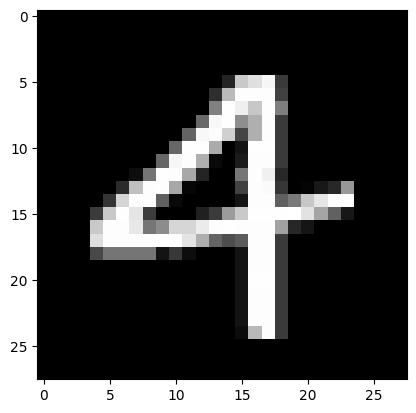

In [15]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(4, W1, b1, W2, b2)
test_prediction(5, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(7, W1, b1, W2, b2)
test_prediction(8, W1, b1, W2, b2)
test_prediction(9, W1, b1, W2, b2)